In [267]:
import requests
import re
import pandas as pd
from urllib.parse import unquote, urlsplit 
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind
from statsmodels.tsa.seasonal import seasonal_decompose



In [283]:
df_en= pd.read_csv('data/df_en.csv')

In [284]:
df_en['timestamp'] = pd.to_datetime(df_en['timestamp'],format='%Y%m%d%H')
df_en.set_index('timestamp',inplace=True)
df_en_weekly = df_en.groupby(pd.Grouper(level='timestamp', freq='W')).sum()


In [339]:
# Calculate the mean pageviews for each philosophy
mean_pageviews = df_en_weekly.mean()
display(mean_pageviews)

# Calculate the threshold as 5% of the max mean
threshold = 0.1*mean_pageviews.max()
#print(threshold)
#print(len(mean_pageviews[mean_pageviews < threshold].index))

# Drop columns with a mean below the threshold
df_en_weekly = df_en_weekly.drop(columns=mean_pageviews[mean_pageviews < threshold].index)

Aesthetics        14210.592357
Agnosticism       20933.490446
Anarchism         22600.961783
Anarchy           10475.757962
Animism           11816.025478
                      ...     
Theology           8119.694268
Transhumanism     10770.585987
Utilitarianism    16357.426752
Zen               12888.687898
Zoroastrianism    45930.910828
Length: 68, dtype: float64

In [287]:
df_en_weekly

,Aesthetics,Agnosticism,Anarchism,Anarchy,Animism,Asceticism,Atheism,Authoritarianism,Baptism,Baptists,...,Socialism,Socrates,Stoicism,Structuralism,Taoism,Theology,Transhumanism,Utilitarianism,Zen,Zoroastrianism
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-01-06,11123.0,21857.0,13544.0,8401.0,9131.0,8449.0,17998.0,7428.0,9163.0,10533.0,...,27074.0,35371.0,22354.0,6380.0,19533.0,6837.0,7459.0,11343.0,11221.0,57548.0
2019-01-13,13692.0,25917.0,20601.0,7955.0,12129.0,10093.0,20912.0,11351.0,14623.0,12235.0,...,35121.0,45865.0,28432.0,10089.0,23945.0,9028.0,8215.0,17115.0,14151.0,62334.0
2019-01-20,14302.0,25382.0,22822.0,8005.0,12370.0,10375.0,19913.0,11666.0,13778.0,12780.0,...,36079.0,45653.0,28405.0,9827.0,26314.0,9776.0,9731.0,19163.0,13503.0,57487.0
2019-01-27,13328.0,29278.0,19095.0,8205.0,11712.0,10380.0,19933.0,10311.0,11689.0,12485.0,...,45873.0,45946.0,26745.0,9675.0,24255.0,9450.0,8151.0,19223.0,13159.0,61678.0
2019-02-03,13268.0,24675.0,18651.0,7606.0,11818.0,10422.0,19988.0,10161.0,11877.0,13180.0,...,39677.0,47998.0,25860.0,9759.0,23298.0,8795.0,8794.0,19405.0,13104.0,60216.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-05,15125.0,16664.0,18512.0,7601.0,12199.0,10225.0,17929.0,12783.0,9929.0,10686.0,...,28102.0,35838.0,35947.0,8702.0,20867.0,7394.0,12192.0,15509.0,11097.0,38242.0
2021-12-12,15344.0,17884.0,18150.0,7358.0,12451.0,10214.0,17218.0,14625.0,9442.0,10723.0,...,28998.0,33772.0,34576.0,8910.0,20754.0,6878.0,12440.0,16668.0,12109.0,38441.0
2021-12-19,14638.0,18557.0,15768.0,6865.0,11883.0,10809.0,16740.0,13293.0,8730.0,10276.0,...,29326.0,31040.0,32108.0,7809.0,20140.0,7121.0,11443.0,14775.0,13966.0,38452.0


In [338]:
# Milestones dates : 
#First case
t0 = '2020-02-16'
#Mobility 
#t1 = '2020-03-15'
#Normalcy 
t1 = '2020-06-21'

In [335]:
df_before = df_en_weekly[df_en_weekly.index<= t0]
df_t0t1 = df_en_weekly[(df_en_weekly.index<= t1) & (df_en_weekly.index>t0)]
df_after = df_en_weekly[df_en_weekly.index>t1]


In [336]:
print(len(df_before.index),len(df_t0t1.index),len(df_after.index))

57 20 80


## T-test for mean views between periods

In [41]:
# Compare : before covid / between first case and lockdown 
articles = df_en.columns[1:]
print('Change change between in mean views between the periode beofre first case and the periode between 1st case and lockdown :\n')
for article in articles : 

    result = ttest_ind(df_before[article], df_t0t1[article], equal_var=False)
    if result.pvalue < 0.05 : 
        print(article, ' : significant change')
        #plt.plot(df_before['timestamp'],df_before[article])
        #plt.plot(df_t0t1['timestamp'],df_t0t1[article])
        #plt.show()
    else :
        print( article, ' : can not reject H0')


Change change between in mean views between the periode beofre first case and the periode between 1st case and lockdown :

Agnosticism  : can not reject H0
Analytic philosophy  : significant change
Anarchism  : can not reject H0
Anarchy  : can not reject H0
Animism  : can not reject H0
Asceticism  : can not reject H0
Atheism  : significant change
Authoritarianism  : significant change
Baptism  : can not reject H0
Baptists  : significant change
Behaviorism  : can not reject H0
Capitalism  : significant change
Categorical imperative  : significant change
Communism  : significant change
Confucianism  : can not reject H0
Consequentialism  : can not reject H0
Conservatism  : significant change
Continental philosophy  : significant change
Critical theory  : can not reject H0
Cynicism (philosophy)  : significant change
Deconstruction  : can not reject H0
Deism  : significant change
Determinism  : can not reject H0
Dialectic  : significant change
Dialectical materialism  : significant change
E

### Test with trends and not means 

In [ ]:
#Index correspondants aux périodes : 
#before --> t0 : 0-57
#t0-->t1 : 58-62
#t1-->t2 :63-75
#t2--> after : 76-156


In [120]:
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import mannwhitneyu

In [ ]:
articles = df_en.columns[1:]

### Period 1 : before ==> t0

In [134]:
changed_at_t0 =[]
changed_at_t1=[]
changed_at_t2=[]

#print('Change  between in mean views between the periode beofre first case and the periode between 1st case and lockdown :\n')
for article in articles:

    decompose_result = seasonal_decompose(df_en_weekly[article],period=52)
    trend = decompose_result.trend
    trend_before = trend[38:58]
    trend_t0t1 = trend[58:63]
    trend_t1t2 = trend[63:76]
    trend_after =trend[76:128]
    #print(len(trend_before),len(trend_t0t1))
    #decompose_result.plot()
    result_t0 = mannwhitneyu(trend_before,trend_t0t1)
    result_t1 =mannwhitneyu(trend_t1t2, trend_t0t1)
    result_t2 =  mannwhitneyu(trend_t1t2, trend_after)
    if result_t0.pvalue < 0.01 : 
        changed_at_t0.append(article)
    if result_t1.pvalue < 0.01 : 
        changed_at_t1.append(article)
    if result_t2.pvalue < 0.01 : 
        changed_at_t2.append(article)
        #plt.plot(df_en_weekly.index[54:59],trend_before)
        #plt.plot(df_en_weekly.index[58:63],trend_t0t1)
        #plt.xticks(rotation=45)
        #plt.title(article)
        #plt.show()
    #else :
     #   print( article, ' : can not reject H0')


Change  between in mean views between the periode beofre first case and the periode between 1st case and lockdown :



In [135]:
len(changed_at_t0)

83

In [136]:
len(changed_at_t1)

76

In [137]:
len(changed_at_t2)

74

In [138]:
most_change = list(set(changed_at_t0) & set(changed_at_t1) & set(changed_at_t2))

In [141]:
most_change

['Neoplatonism',
 'Political philosophy',
 'Luddite',
 'Stoicism',
 'Nihilism',
 'Hedonism',
 'Ontology',
 'Neoliberalism',
 'Jainism',
 'Critical theory',
 'Philosophy of language',
 'Liberalism',
 'Dialectic',
 'Animism',
 'Rastafari',
 'Kabbalah',
 'Pantheism',
 'Relativism',
 'Agnosticism',
 'Authoritarianism',
 'Philosophy of religion',
 'Personalism',
 'Structuralism',
 'Feminist philosophy',
 'Maoism',
 'Platonism',
 'Manichaeism',
 'Post-structuralism',
 'Philosophy of mind',
 'Baptists',
 'Epistemology',
 'Gnosticism',
 'Behaviorism',
 'Consequentialism',
 'Dialectical materialism',
 'Zen',
 'Romanticism',
 'Historical materialism',
 'Scholasticism',
 'Reductionism',
 'Philosophy of science',
 'Baptism']

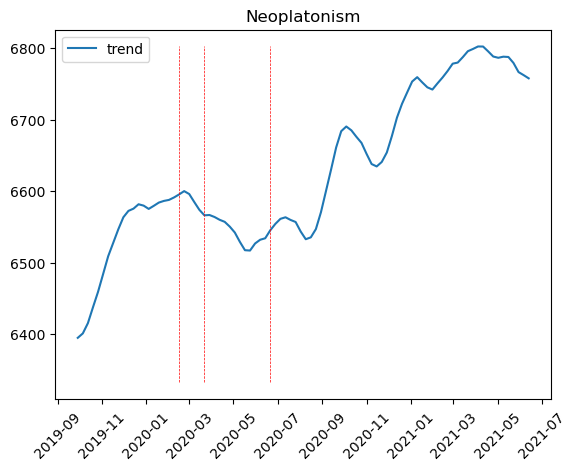

In [167]:
for art in most_change[0:1]:

    decompose_result = seasonal_decompose(df_en_weekly[art],period=52)
    trend = decompose_result.trend
    trend_before = trend[38:58]
    trend_t0t1 = trend[58:63]
    trend_t1t2 = trend[63:76]
    trend_after =trend[76:128]

    plt.plot(df_en_weekly.index[38:128],trend[38:128],label='trend')
    plt.vlines([df_en_weekly.index[58],df_en_weekly.index[63],df_en_weekly.index[76]],np.min(trend),np.max(trend),color='r',linestyles='--',linewidth=0.5)
    plt.xticks(rotation=45)
    plt.title(art)
    plt.legend()
    plt.show()

In [404]:
def diff_percentage(x1,x2):
    return (np.abs(x2)-np.abs(x1))/np.abs(x1)*100
        

In [411]:
def plot_regression_on_segments(df,article,segments,threshold):
    
    # Example data
    decompose_result = seasonal_decompose(df[article],period=52)
    trend = decompose_result.trend
    trend_series = pd.Series(trend)
    plt.plot(trend_series.index[segments[0][0]:segments[2][1]], trend_series[segments[0][0]:segments[2][1]], label='Original Trend',linewidth=0.5)


    # Define the segments and change points
    timepoints = [segments[0][1], segments[1][1]]
    change_indices=[]

    slopes =[]
    intercepts=[]
    diff_slope = []
    diff_intercept=[]
    type_diff = []
    # Fit segmented regression models and plot the segmented regression lines
    j=0
    for start, end in segments:
        X_segment = sm.add_constant(np.arange(start, end))
        model_segment = sm.OLS(trend_series[start:end], X_segment)
        results_segment = model_segment.fit()
        slopes.append(results_segment.params.iloc[1])
        intercepts.append(results_segment.params.iloc[0])
        # Plot the segmented regression lines
        plt.plot(trend_series.index[start:end], results_segment.predict(X_segment), label=f'Segment period {j}',linestyle='--',linewidth=1.5)
        j+=1
   
    #Compare the slopes 
    for i in [0,1]:
        diff= diff_percentage(slopes[i],slopes[i+1])
        diff_intercept.append(intercepts[i]-intercepts[i+1])
        if slopes[i+1]*slopes[i]>0 and diff>0:
            type_diff.append('acceleration')
            if slopes[i]<0:
                diff= -diff
        elif slopes[i+1]*slopes[i]>0 and diff<0 :
            type_diff.append('deceleration')
            if slopes[i]>0:
                diff=-diff
        
        elif slopes[i+1]*slopes[i]<0 :
            type_diff.append('direction change')

        if diff >threshold or diff<-threshold : 
            #print('Significant change in trend between period ',i,' and period ',i+1)
            change_indices.append(timepoints[i])
        #else :
           # print('No significant change in trend between period ',i,' and period ',i+1)
        diff_slope.append(diff)

    print(type_diff)  
    
    same_indices = list(set(timepoints)-set(change_indices))
    # Mark the change points
    plt.scatter(trend_series.index[change_indices], trend_series.iloc[change_indices], color='red', marker='o', label='Change')
    plt.scatter(trend_series.index[same_indices], trend_series.iloc[same_indices], color='black', marker='x', label='No change')
    plt.title(article)
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()
    return diff_slope,diff_intercept, type_diff


        

In [409]:
# Select the top 5 and bottom 5 values
def plot_biggest_change(ax, df, col_to_sort):
    df_sorted = df.sort_values(by=col_to_sort, ascending=False)
    top_5 = df_sorted.head(10)
    bottom_5 = df_sorted.tail(10)

    # Plot the bar chart on the specified Axes object
    ax.bar(top_5.index, top_5[col_to_sort], color='green', label='Top positive change')
    ax.bar(bottom_5.index, bottom_5[col_to_sort], color='red', label='Top negative change')

    # Add labels and legend
    ax.set_xlabel('Philosophies')
    ax.set_ylabel('Percentage change in trend')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
    ax.set_title(col_to_sort)
    ax.legend()

['direction change', 'negative acceleration']


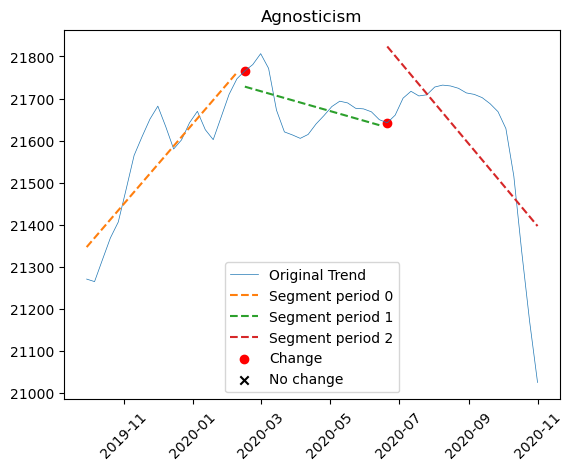

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['positive deceleration', 'positive deceleration']


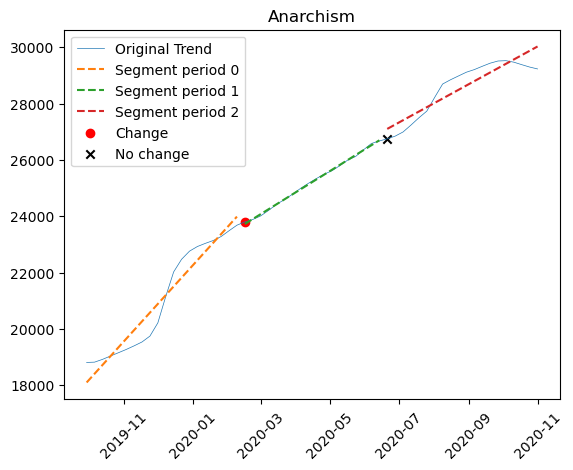

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['positive deceleration', 'positive deceleration']


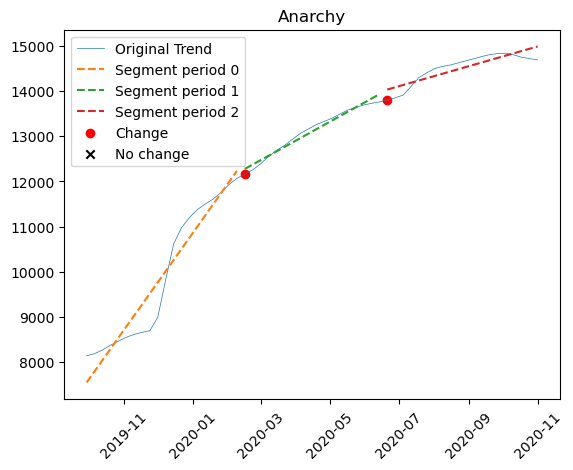

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['positive deceleration', 'positive acceleration']


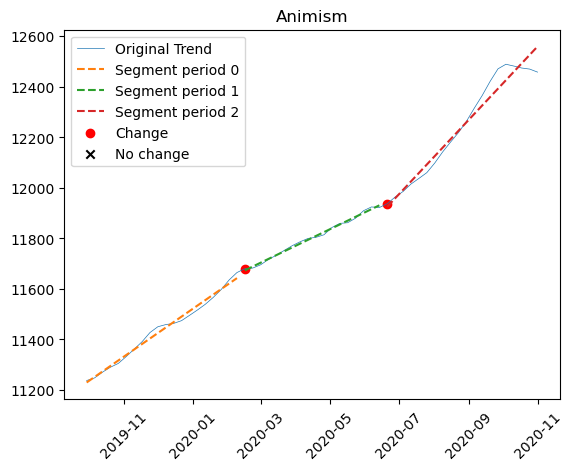

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['positive deceleration', 'positive deceleration']


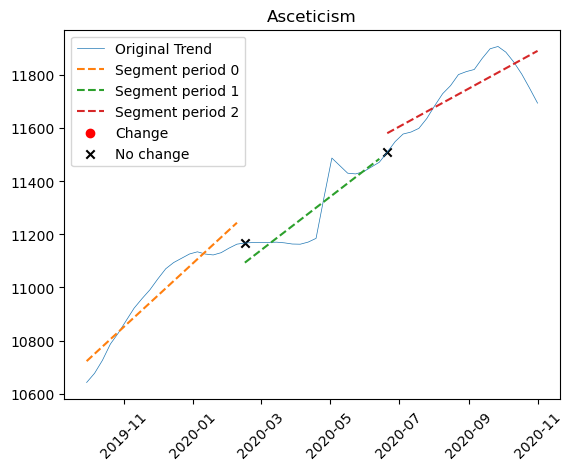

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['direction change', 'direction change']


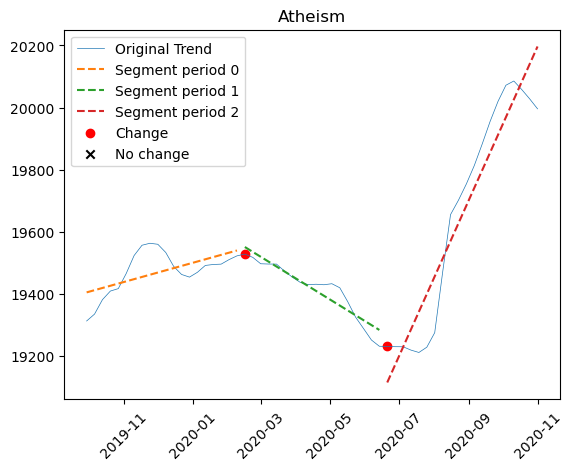

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['positive acceleration', 'positive deceleration']


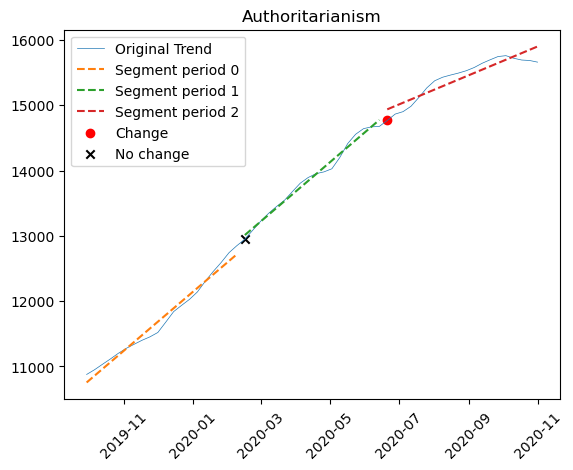

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['negative acceleration', 'negative acceleration']


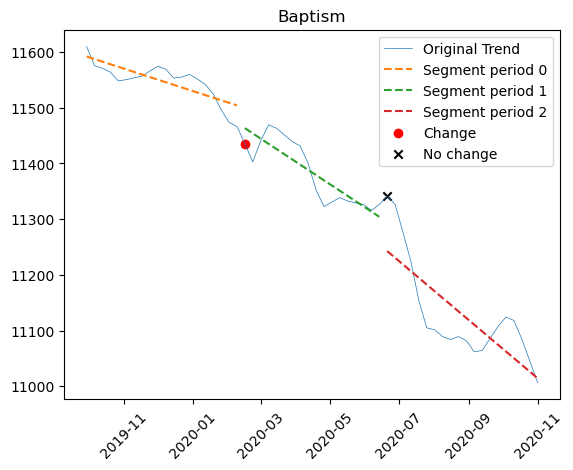

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['negative acceleration', 'negative deceleration']


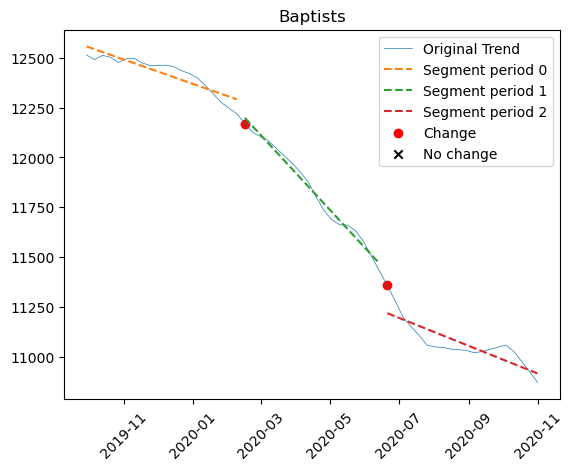

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['negative deceleration', 'negative deceleration']


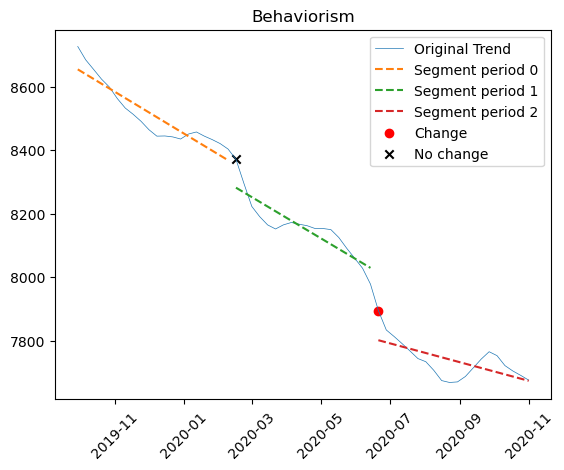

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['positive deceleration', 'positive deceleration']


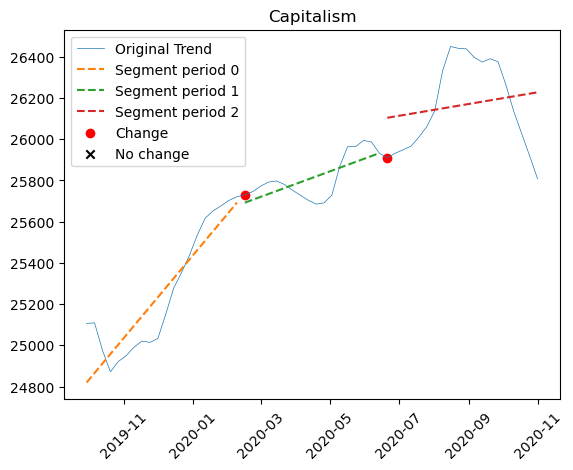

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['positive deceleration', 'positive deceleration']


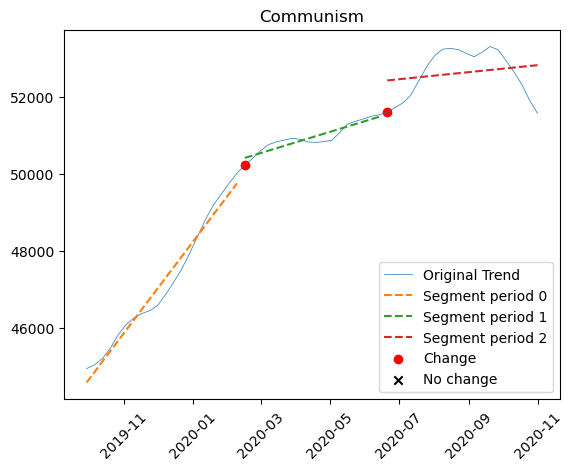

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['positive deceleration', 'positive acceleration']


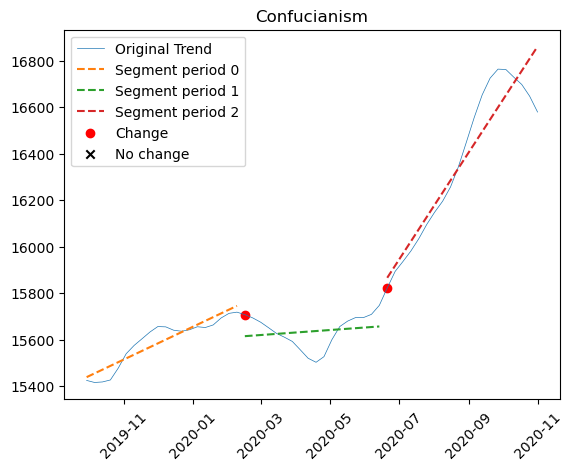

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['positive acceleration', 'positive deceleration']


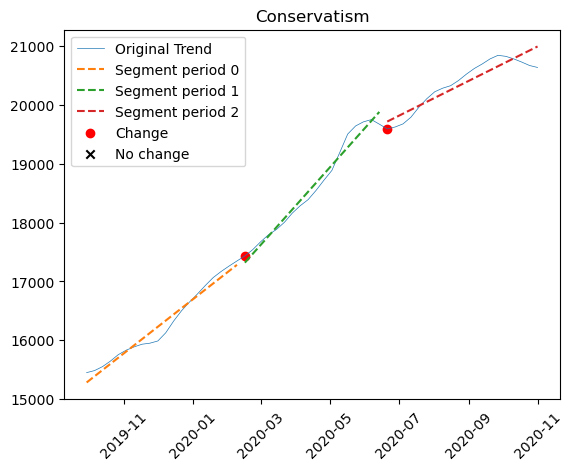

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['positive acceleration', 'positive deceleration']


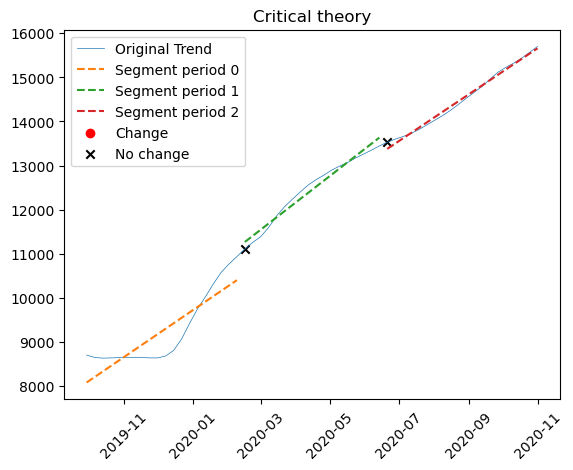

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['positive deceleration', 'positive acceleration']


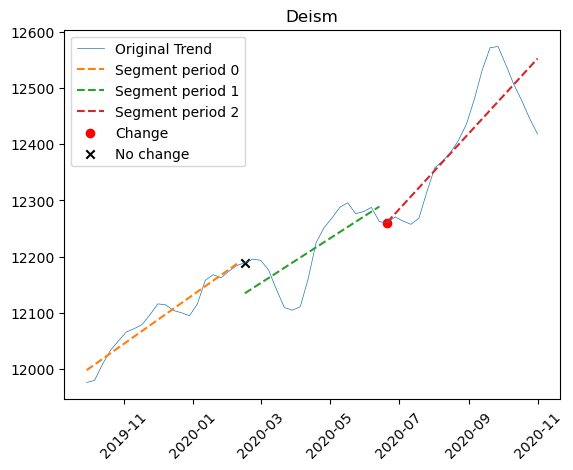

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['positive deceleration', 'positive acceleration']


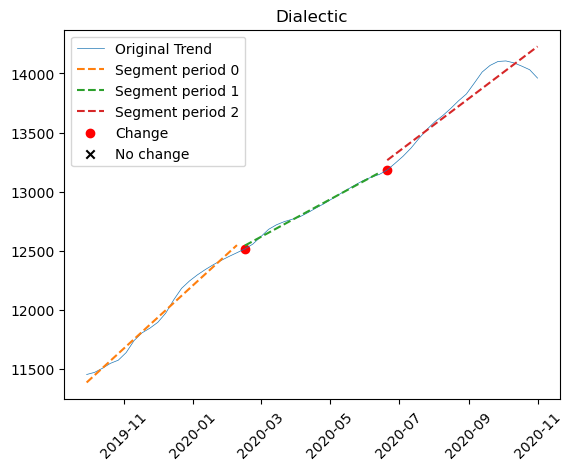

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['positive acceleration', 'positive deceleration']


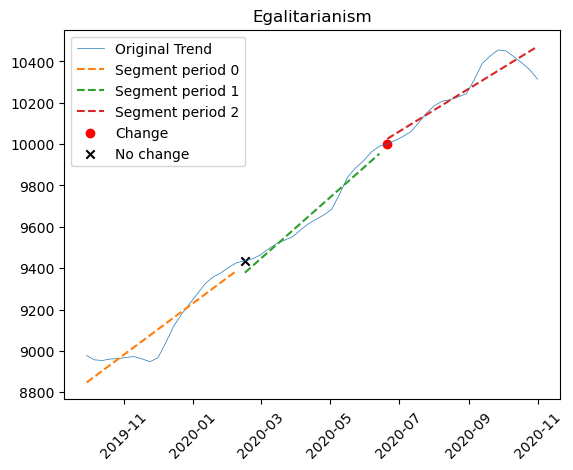

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['positive acceleration', 'positive acceleration']


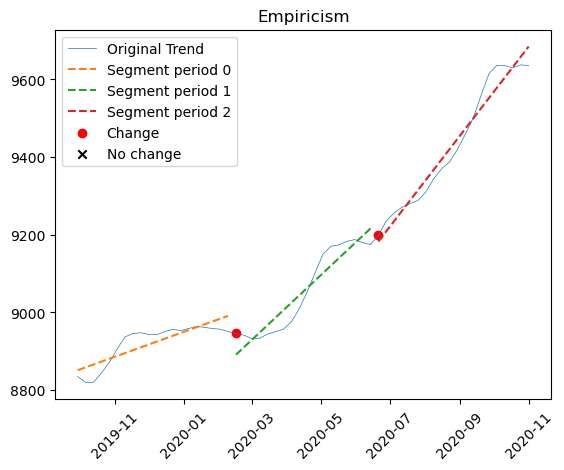

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['positive acceleration', 'positive acceleration']


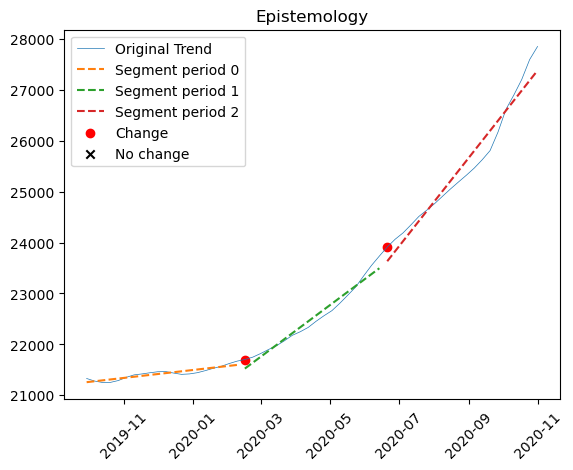

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['negative deceleration', 'direction change']


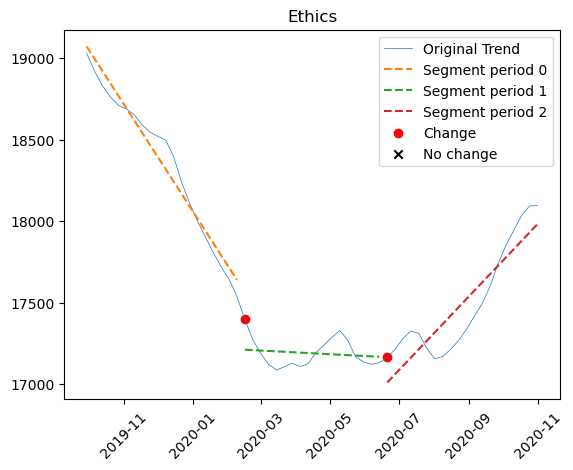

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['positive acceleration', 'positive deceleration']


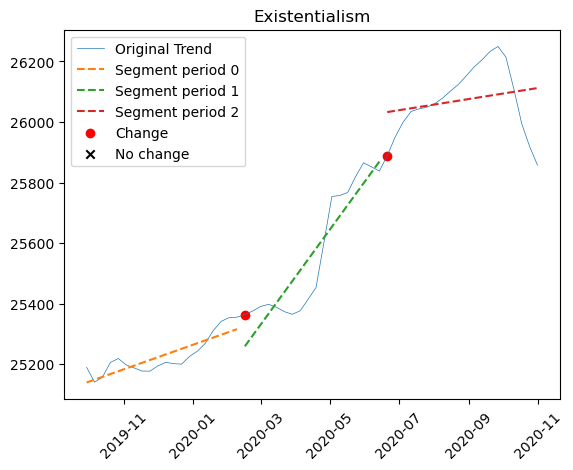

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['positive deceleration', 'positive deceleration']


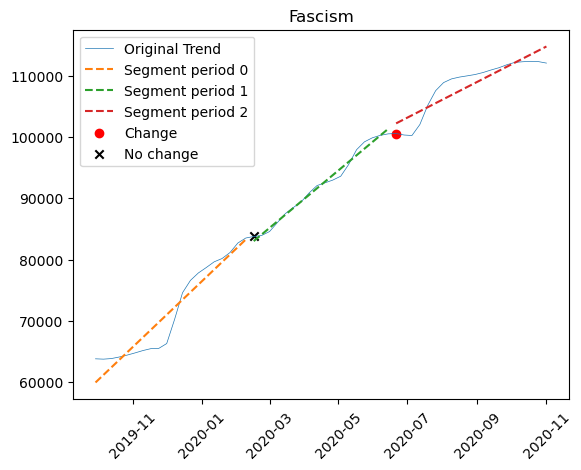

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['positive acceleration', 'positive deceleration']


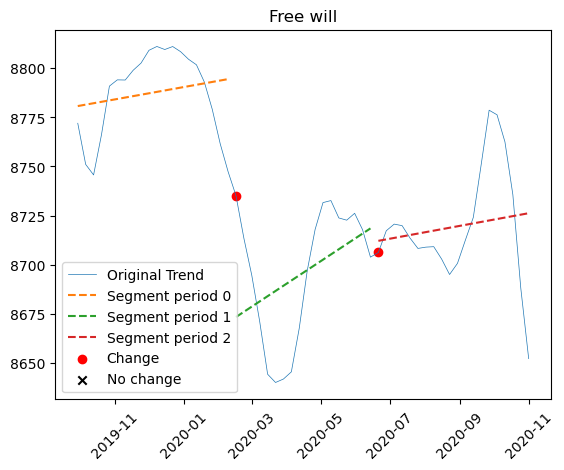

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['positive deceleration', 'positive acceleration']


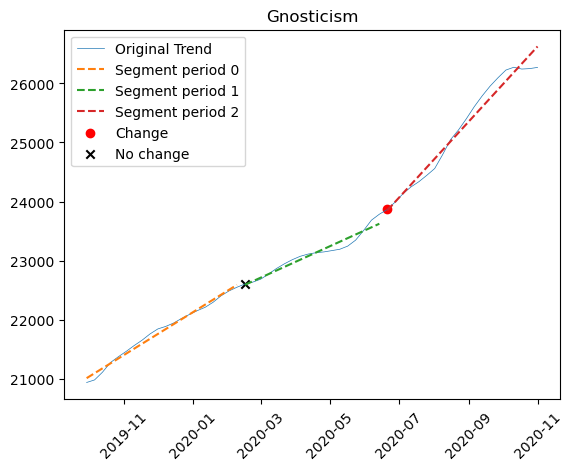

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['positive acceleration', 'positive acceleration']


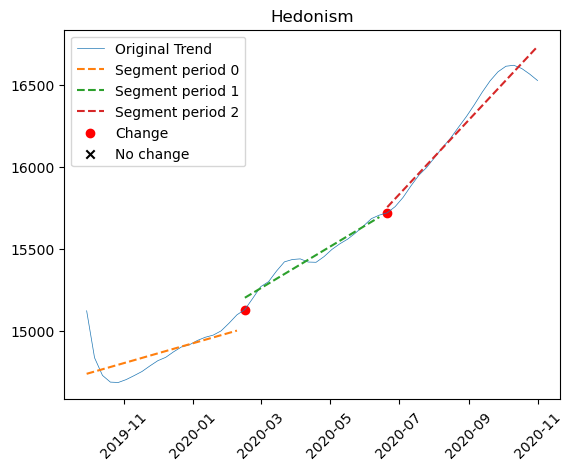

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['positive deceleration', 'positive deceleration']


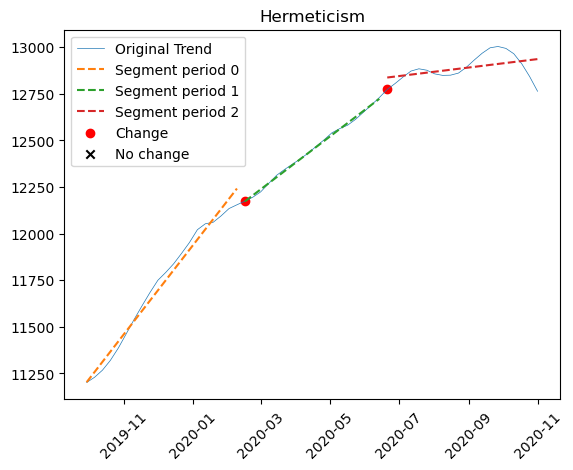

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['positive deceleration', 'positive acceleration']


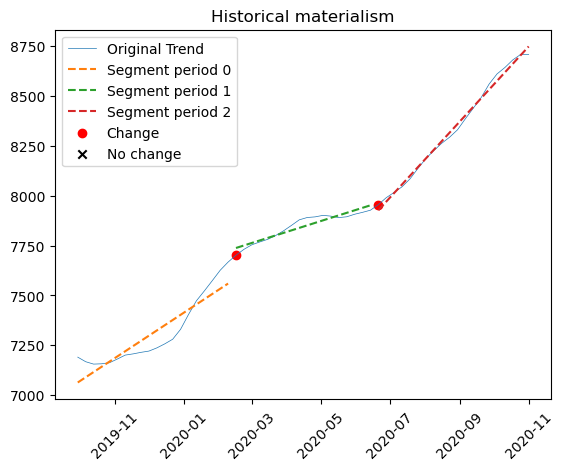

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['positive acceleration', 'positive acceleration']


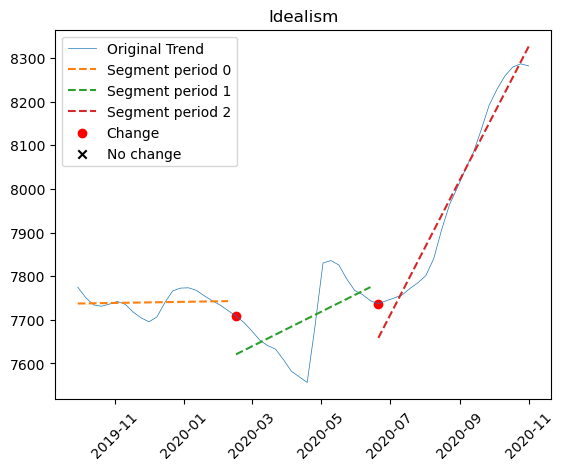

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['negative acceleration', 'direction change']


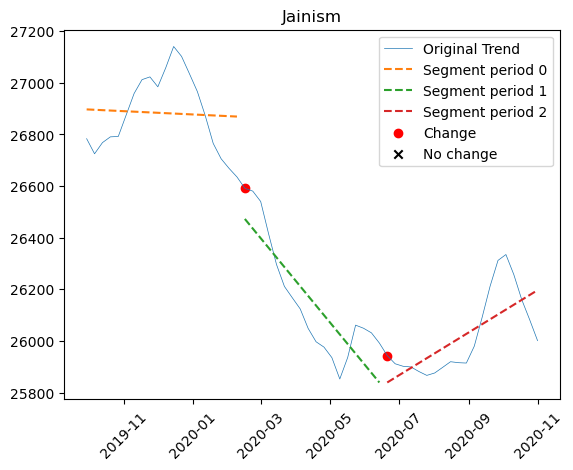

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['positive deceleration', 'positive deceleration']


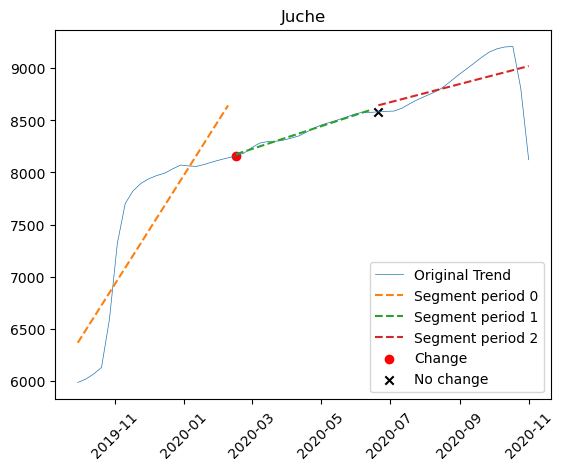

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['positive deceleration', 'positive deceleration']


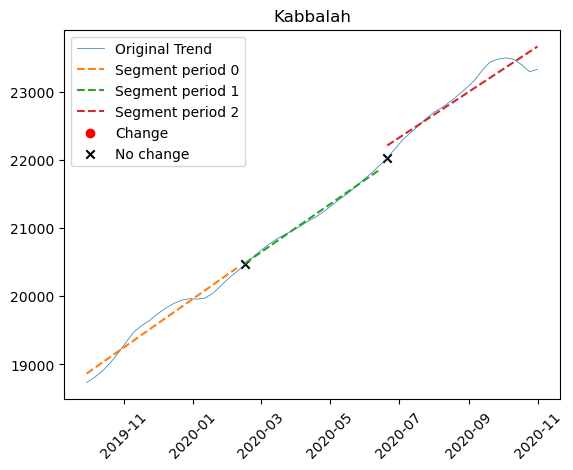

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['positive acceleration', 'positive deceleration']


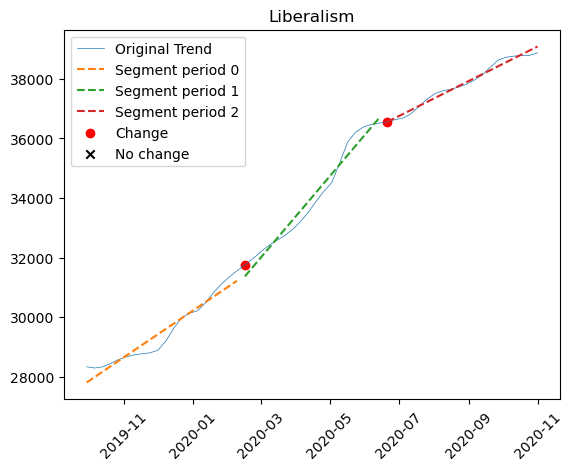

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['positive acceleration', 'positive deceleration']


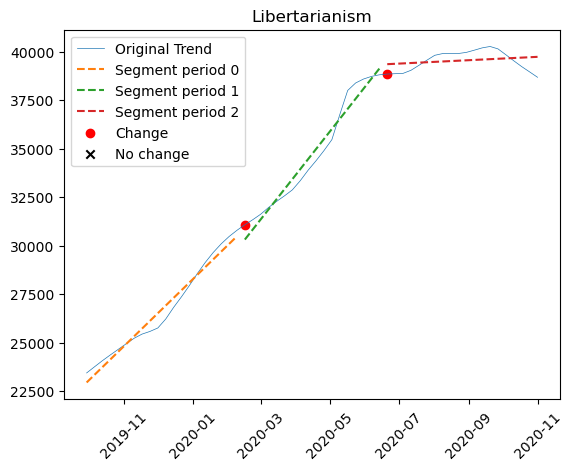

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['positive deceleration', 'direction change']


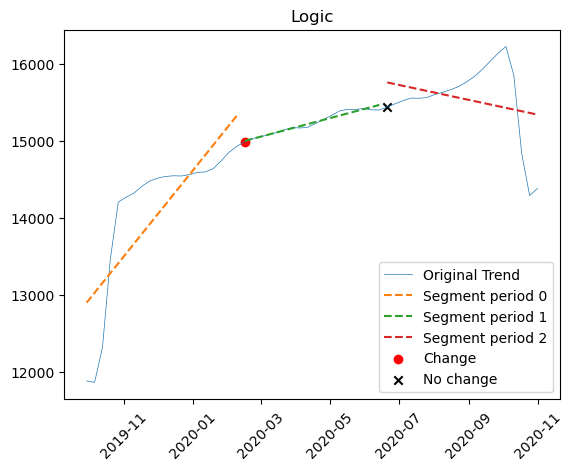

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['positive deceleration', 'positive acceleration']


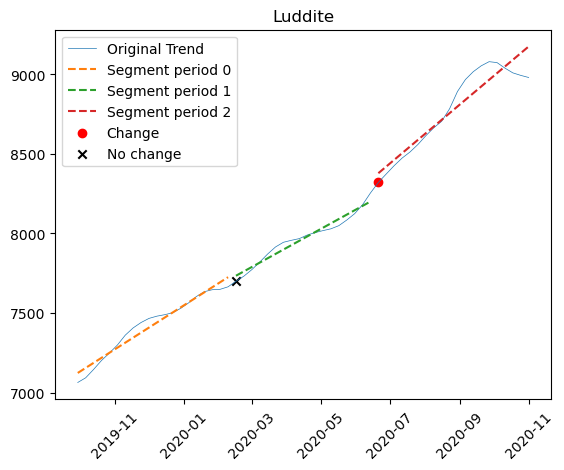

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['positive deceleration', 'positive acceleration']


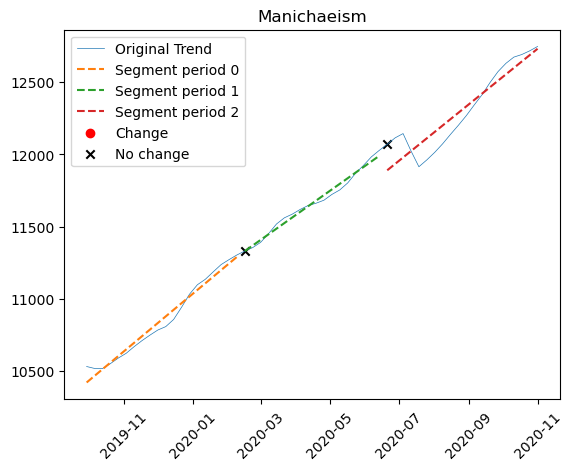

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['positive deceleration', 'positive acceleration']


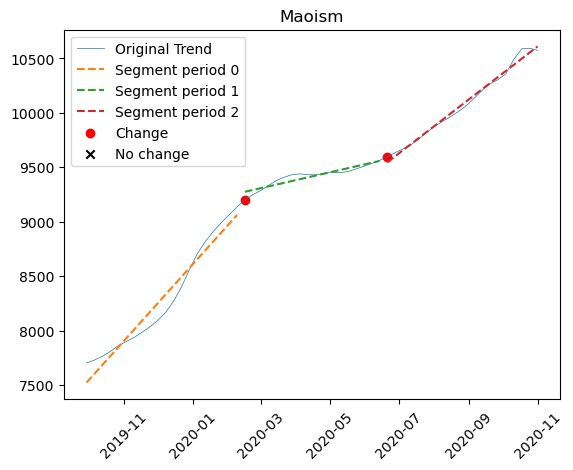

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['positive deceleration', 'positive deceleration']


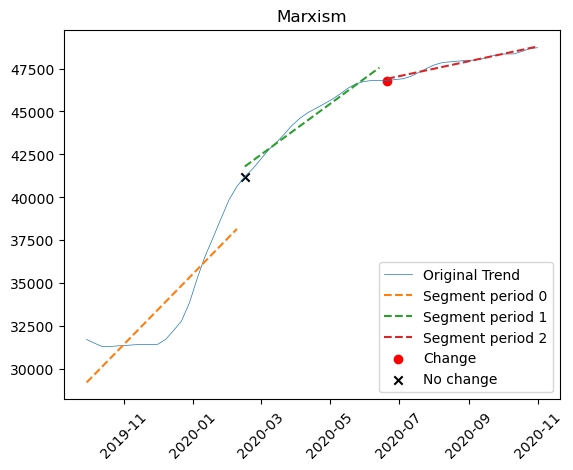

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['direction change', 'positive acceleration']


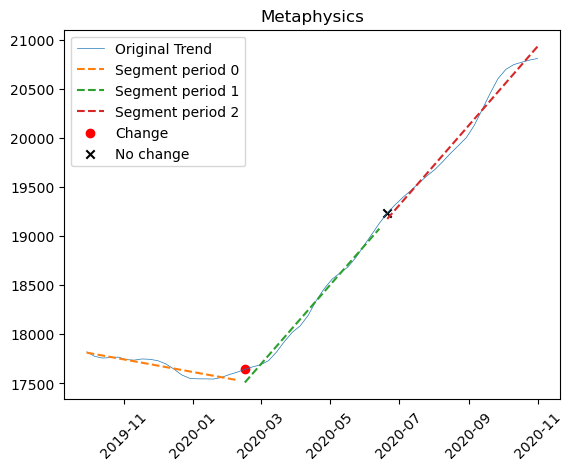

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['direction change', 'direction change']


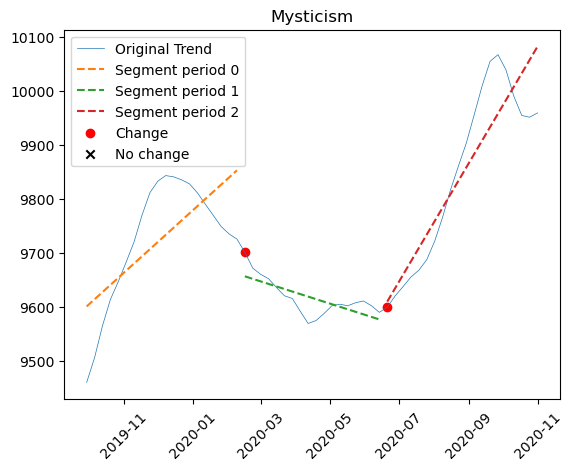

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['positive deceleration', 'positive deceleration']


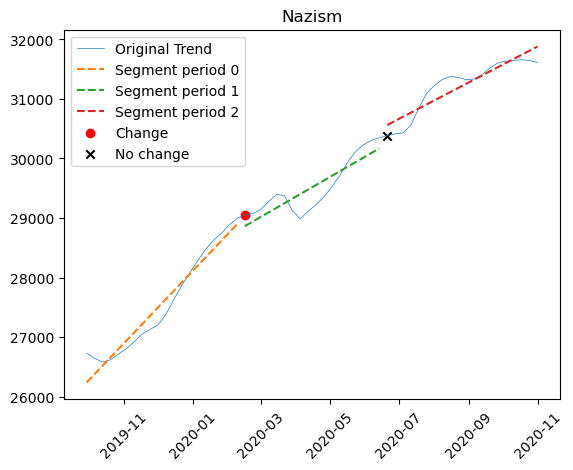

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['positive acceleration', 'positive deceleration']


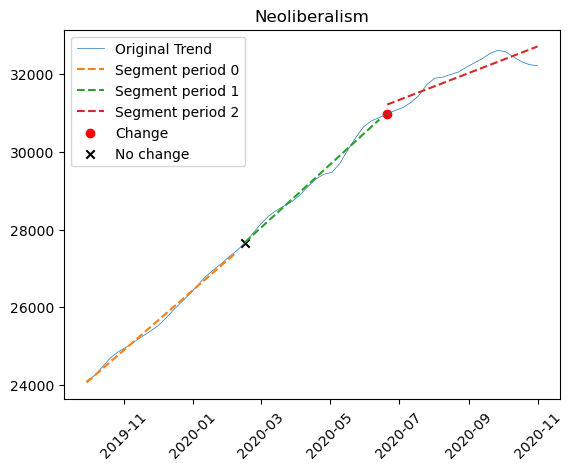

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['positive deceleration', 'positive acceleration']


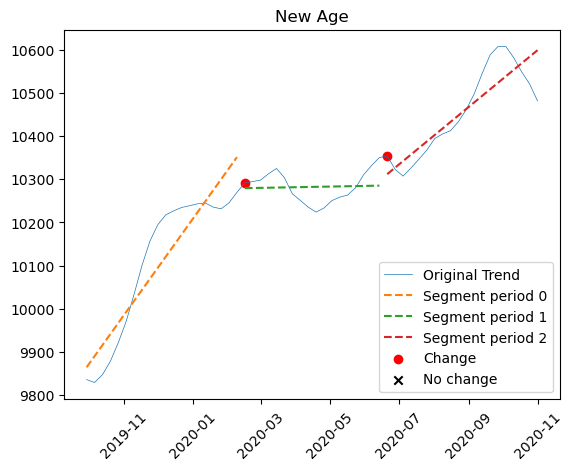

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['positive acceleration', 'positive acceleration']


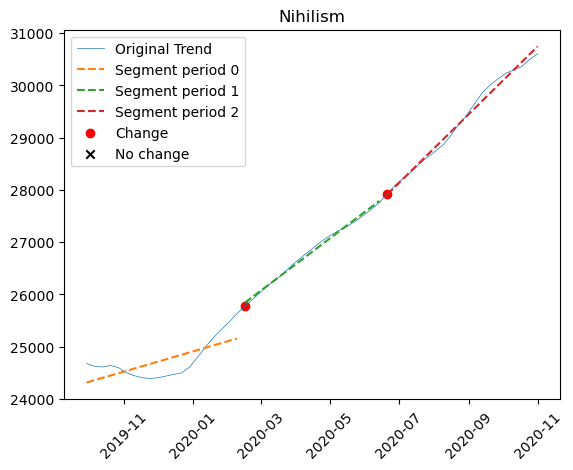

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['negative deceleration', 'direction change']


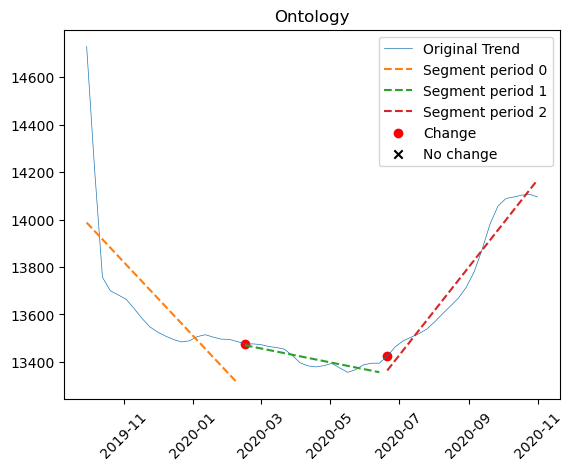

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['direction change', 'negative acceleration']


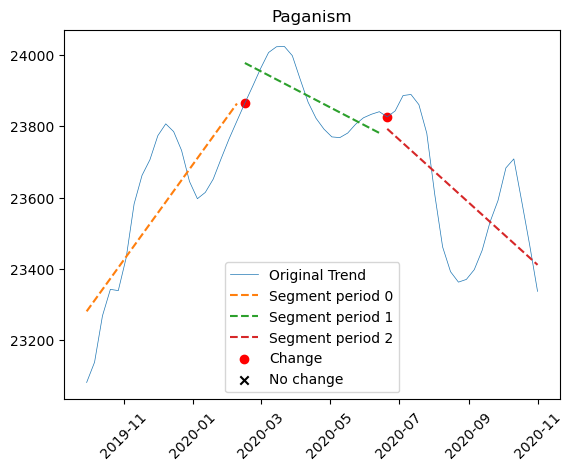

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['negative acceleration', 'negative deceleration']


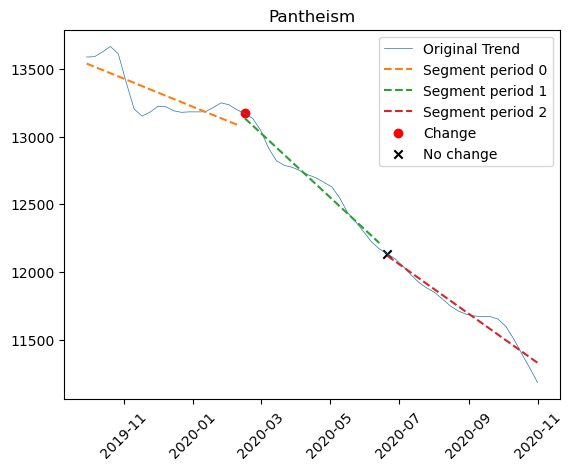

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['direction change', 'positive deceleration']


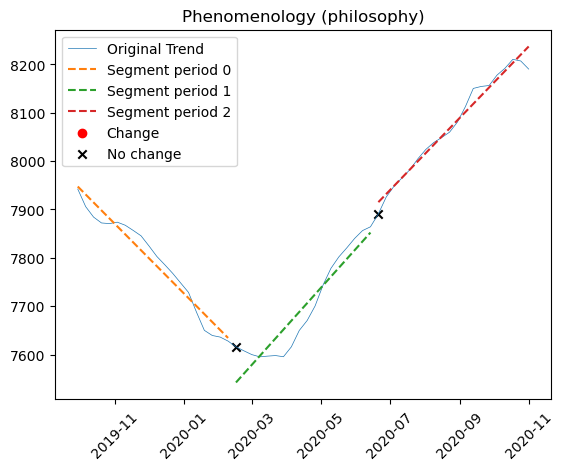

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['positive acceleration', 'positive deceleration']


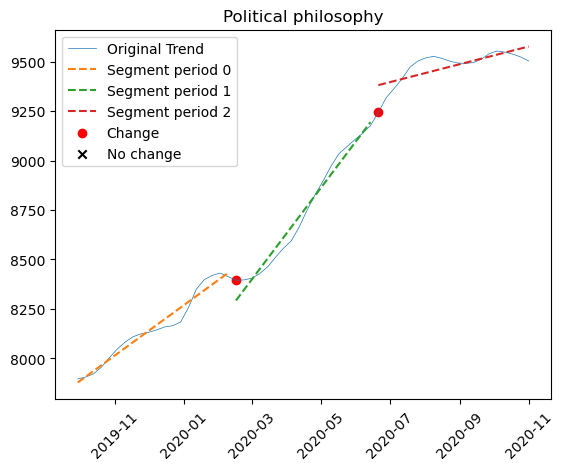

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['direction change', 'positive deceleration']


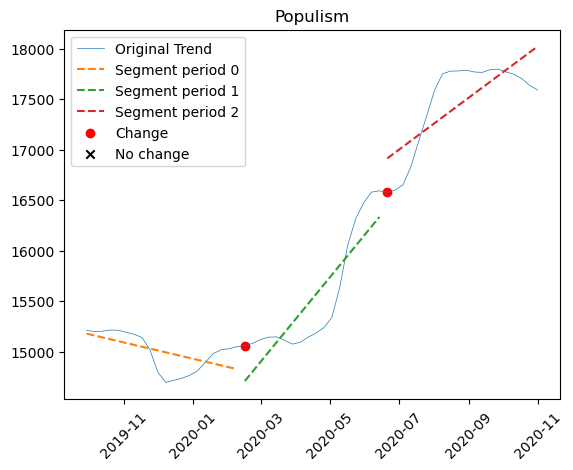

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['direction change', 'positive acceleration']


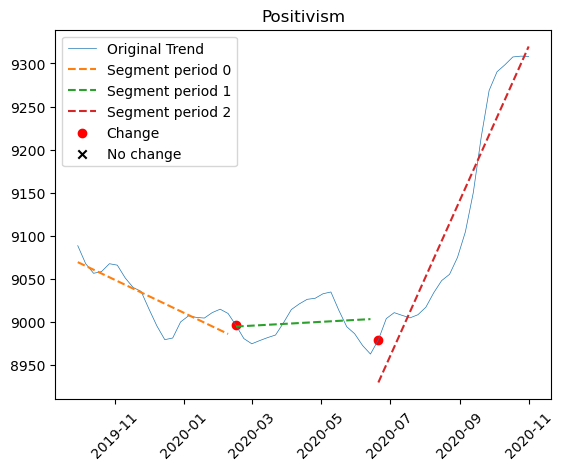

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['positive deceleration', 'positive acceleration']


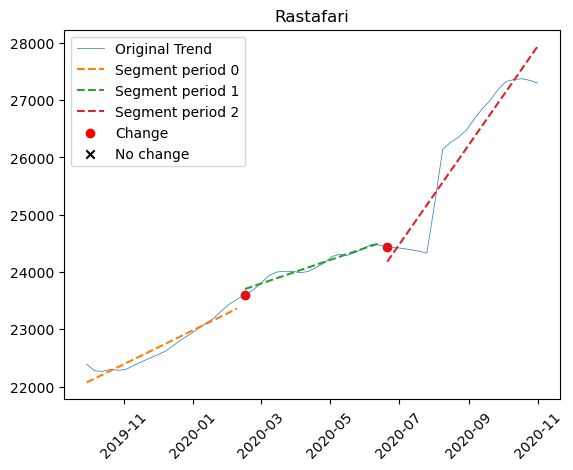

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['positive acceleration', 'positive acceleration']


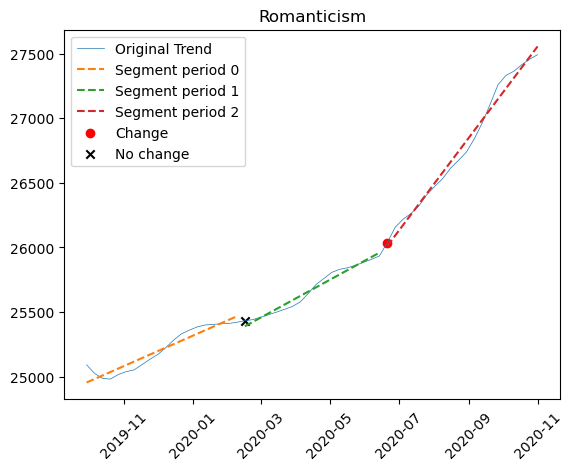

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['positive deceleration', 'positive acceleration']


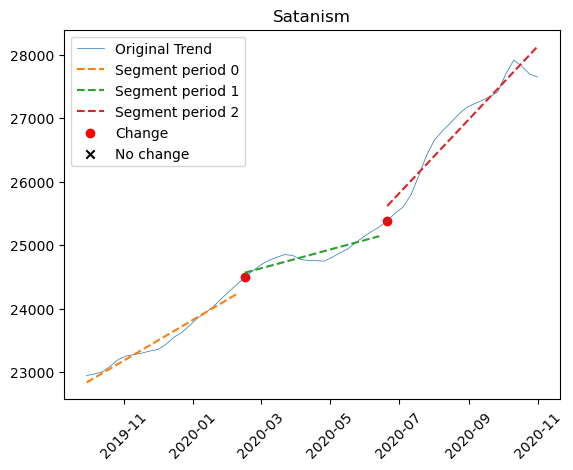

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['direction change', 'direction change']


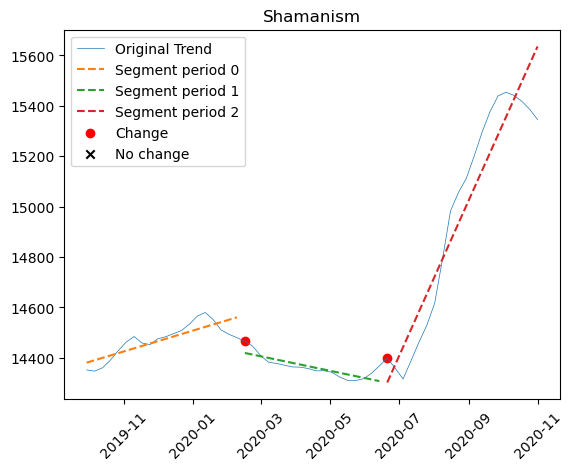

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['positive deceleration', 'positive acceleration']


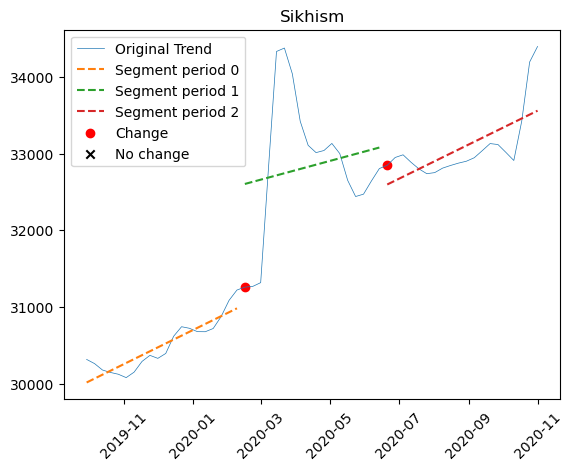

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['positive acceleration', 'direction change']


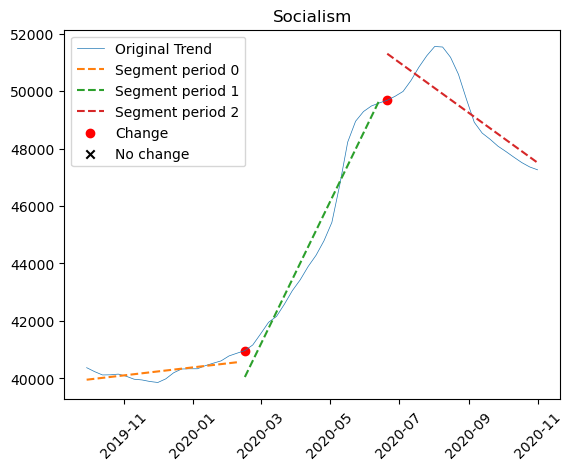

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['direction change', 'positive acceleration']


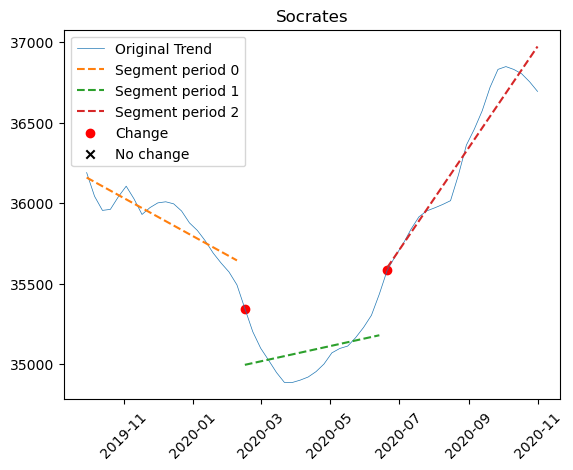

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['positive acceleration', 'positive deceleration']


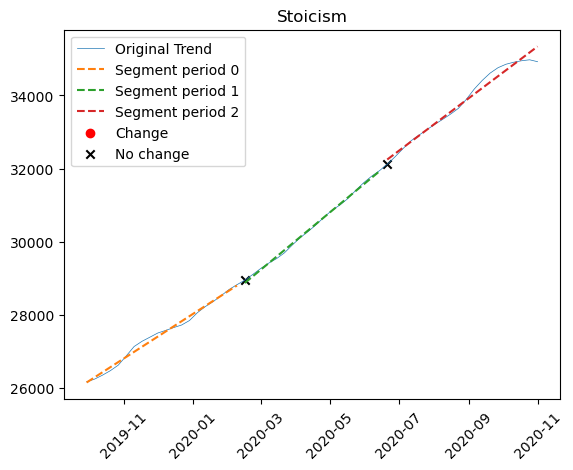

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['direction change', 'positive acceleration']


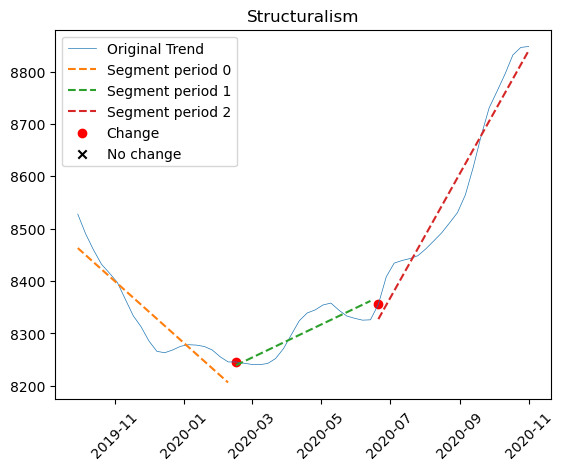

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['direction change', 'direction change']


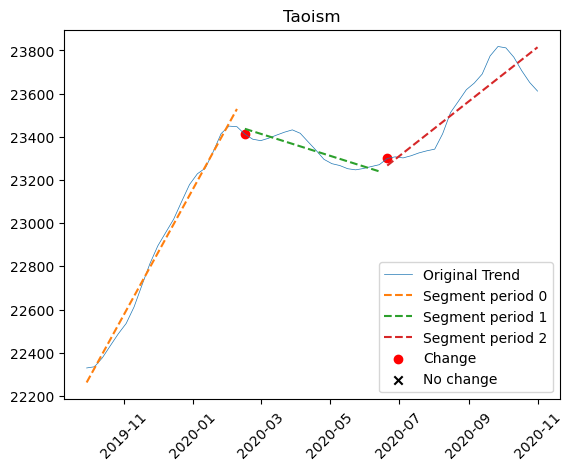

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['direction change', 'direction change']


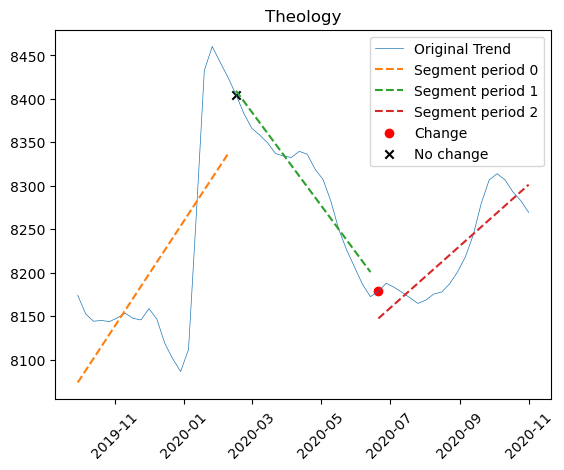

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['positive deceleration', 'positive acceleration']


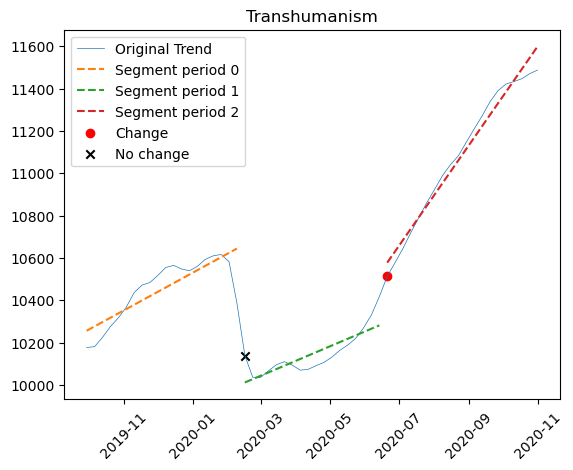

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['positive deceleration', 'positive acceleration']


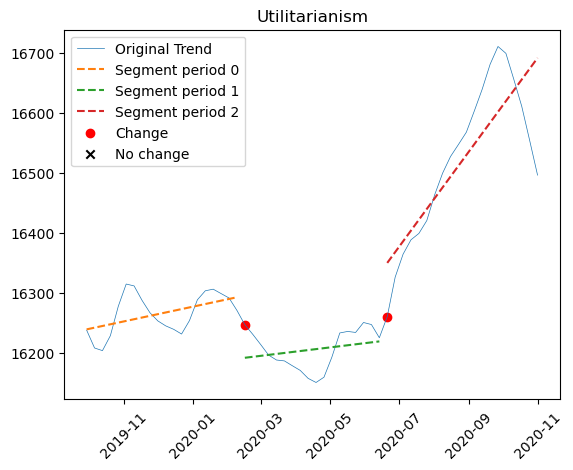

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['direction change', 'direction change']


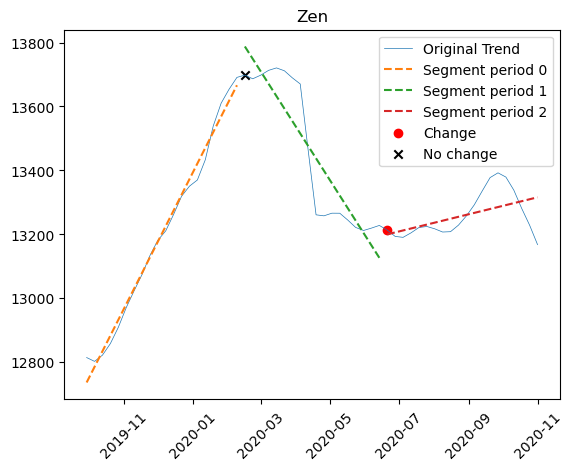

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


['negative deceleration', 'direction change']


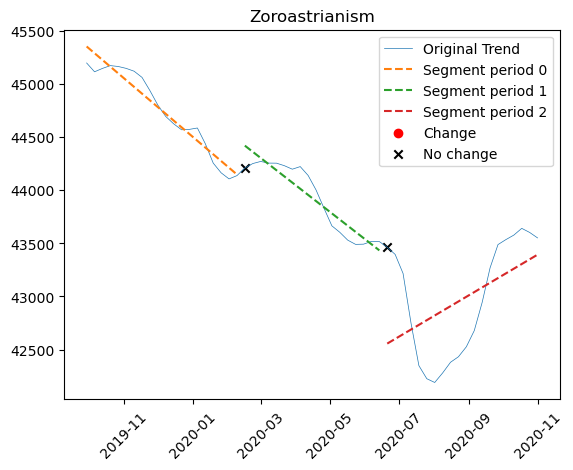

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/4036393375.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


In [410]:
segments = [(38, 58), (58,76), (76, 96)]


trend_changes = pd.DataFrame()
trend_changes['Slope change at t0'] = None
trend_changes['Slope change at t1']=None
trend_changes['Intercept change at t0']=None
trend_changes['Intercept change at t1']=None
trend_changes['Type t0'] = None
trend_changes['Type t1'] = None
for article in articles : 
    diff_slope,diff_intercept,type_trend = plot_regression_on_segments(df_en_weekly,article,segments,30)
    trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':trend[1]}


/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_48051/3879411357.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')


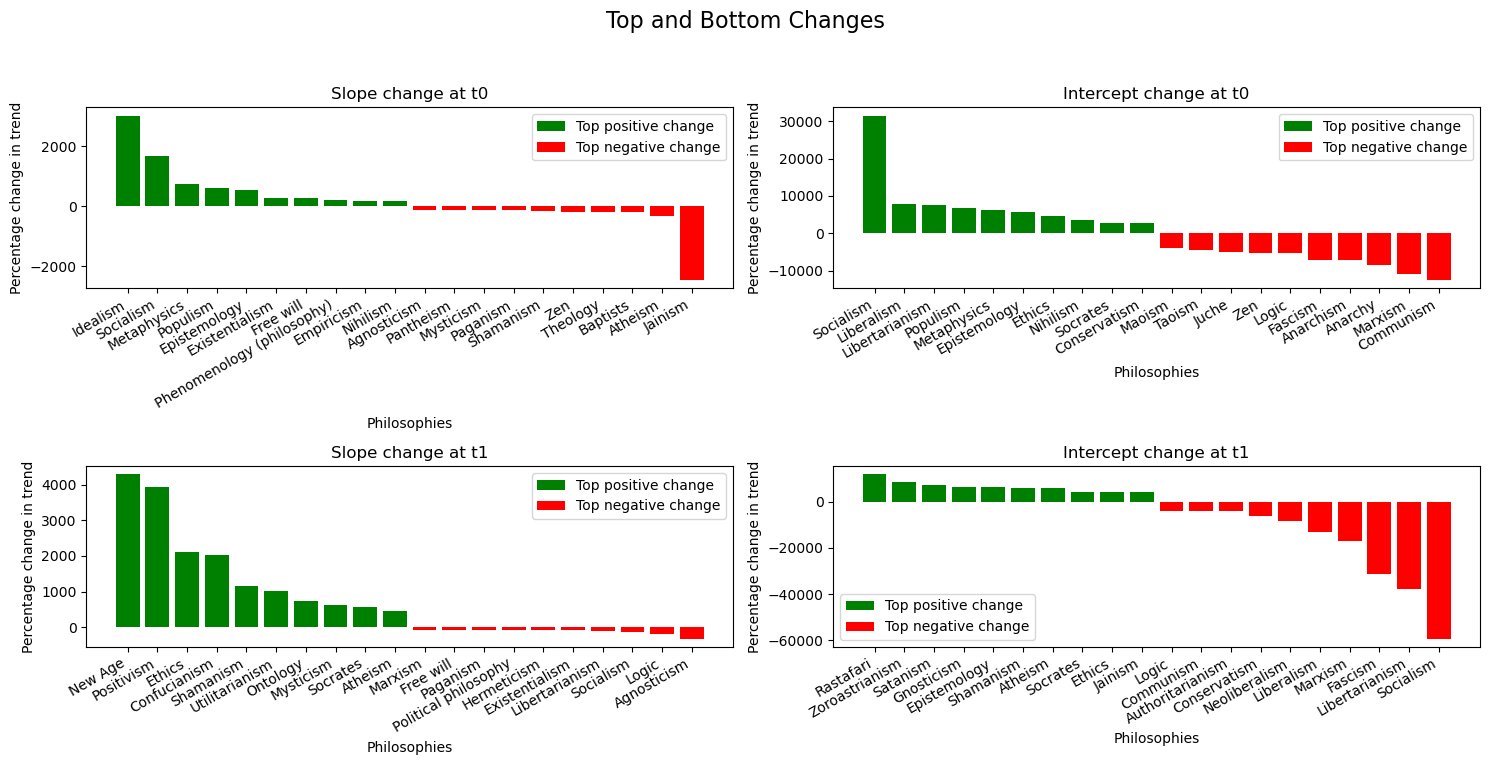

In [384]:
# Example usage:
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
fig.suptitle('Top and Bottom Changes', fontsize=16)

# Flatten the axes if subplot_config is a 2D layout
axes = axes.flatten() if isinstance(axes[0], (list, np.ndarray)) else axes

# Define the column names you want to plot
columns_to_plot = ['Slope change at t0',  'Intercept change at t0','Slope change at t1','Intercept change at t1']

# Iterate through the subplots and plot on each one
for i, ax in enumerate(axes):
    plot_biggest_change(ax, trend_changes, columns_to_plot[i])

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the figure
plt.show()

In [375]:
# Milestones dates : 
#First case
t0 = '2020-02-16'
#Mobility 
#t1 = '2020-03-15'
#Normalcy 
t1 = '2020-06-21'

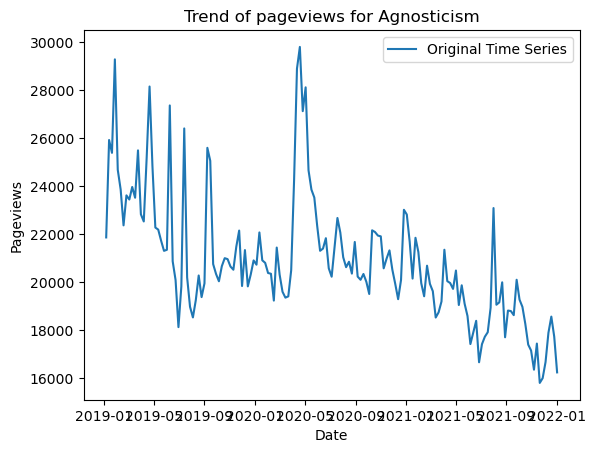

0.01393536166592056 0.15495540132463775


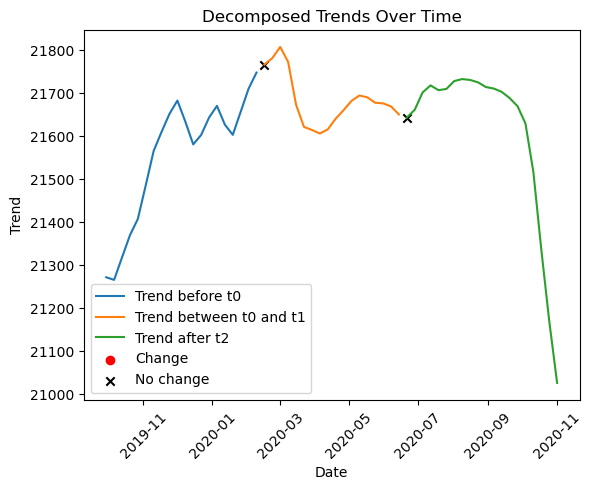

In [376]:
# Plot the original time series
for article in articles[0:1] : 
    plt.plot(df_en_weekly.index, df_en_weekly[article], label='Original Time Series')
    plt.title('Trend of pageviews for '+article)
    plt.xlabel('Date')
    plt.ylabel('Pageviews')
    plt.legend()
    plt.show()


    periods = [(38, 58), (58,76), (76, 96)]
    timepoints = [58, 76]
    change_indices=[]

    #Perform seasonal decomposition on the entire time series
    decomposition = seasonal_decompose(df_en_weekly[article])
    trend = decomposition.trend
    trend_series = pd.Series(trend)

    # Extract trends for each date range
    trend_before_t0 = trend[periods[0][0]:periods[0][1]]
    trend_between_t0_t1 = trend[periods[1][0]:periods[1][1]]
    trend_after_t1 = trend[periods[2][0]:periods[2][1]]

    diff_before_t0 = np.diff(trend_before_t0)
    diff_between_t0_t1 =np.diff(trend_between_t0_t1)
    diff_after_t1 = np.diff(trend_after_t1)

    result_t0 = ttest_ind(diff_before_t0,diff_between_t0_t1)
    result_t1 =ttest_ind(diff_between_t0_t1, diff_after_t1)
    if result_t0.pvalue < 0.01 : 
        change_indices.append(timepoints[0])
    if result_t1.pvalue < 0.01 :
        change_indices.append(timepoints[1]) 

    print(result_t0.pvalue,result_t1.pvalue)
    same_indices = list(set(timepoints)-set(change_indices))

    # Visualize the decomposed trends for each date range
    plt.plot(trend_before_t0.index, trend_before_t0, label='Trend before t0')
    plt.plot(trend_between_t0_t1.index, trend_between_t0_t1, label='Trend between t0 and t1')
    plt.plot(trend_after_t1.index, trend_after_t1, label='Trend after t2')

    plt.scatter(trend_series.index[change_indices], trend_series.iloc[change_indices], color='red', marker='o', label='Change')
    plt.scatter(trend_series.index[same_indices], trend_series.iloc[same_indices], color='black', marker='x', label='No change')

    plt.title('Decomposed Trends Over Time')
    plt.xlabel('Date')
    plt.ylabel('Trend')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()
